<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [72]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import clear_output
from functools import partial

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [73]:
path='/content/sample_data/faces/faces_dataset_small/'

In [74]:
photo = plt.imread('/kaggle/input/faces_dataset_small/00237.png')

photo.shape


(1024, 1024, 3)

Изображения размера 1024х1024

Посмотрим пример фотографии

(-0.5, 1023.5, 1023.5, -0.5)

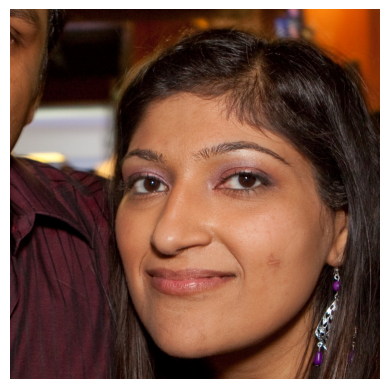

In [75]:
plt.imshow(photo)
plt.axis('off')

In [76]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [77]:
def get_transform(image_size):
    return tt.Compose([
        tt.Resize((image_size, image_size)),
        tt.ToTensor()
    ]
    )

In [78]:
path='/kaggle/input/'

In [79]:
def get_dataloader(image_size, batch_size):

    #Наши преобразования
    transform = get_transform(image_size)

    root_folder = path



    dataset = ImageFolder(root_folder, transform=transform)
    print(len(dataset))
    return DataLoader(dataset, batch_size=batch_size,
                      shuffle=False,
                      num_workers=2,
                     )


In [80]:
image_size = 128

photos_loader = get_dataloader(image_size, batch_size=64)


#TODO: build dataloader and transfer it to device

3143


У нас  есть 3143 фотографии. Их следует отнормировать к мю 0, сигма 1
Посмотрим распределение для этих картинок

In [81]:
#сделаем батч из всех картинок сета
photos_loader = get_dataloader(image_size, batch_size=3143)
photos = next(iter(photos_loader))


3143


In [82]:
photos[0].size()

torch.Size([3143, 3, 128, 128])

Посчитаем mu и sigma для каждого цвета

In [83]:

mu, std = photos[0].mean(dim=(0,2,3)), photos[0].std(dim=(0,2,3))

print(mu, std)

tensor([0.5232, 0.4279, 0.3824]) tensor([0.2793, 0.2541, 0.2556])


Перепишем функцию чтобы у нас еще была нормализация

In [84]:
def get_transform(image_size):
    return tt.Compose([
        tt.Resize((image_size, image_size)),
        tt.ToTensor(),
        tt.Normalize(mu,std)
    ]
    )

In [85]:
image_size = 128
batch_size = 64

photos_loader = get_dataloader(image_size, batch_size=batch_size)


3143


In [86]:

for images, _ in photos_loader:
    print(images.size())
    break

torch.Size([64, 3, 128, 128])


Посмотрим все ли ок с картинками после трансформаций

In [87]:


def denorm(img_tensors):
    return img_tensors * std.view(1,3,1,1) + mu.view(1,3,1,1) #денормировка

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach().cpu()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

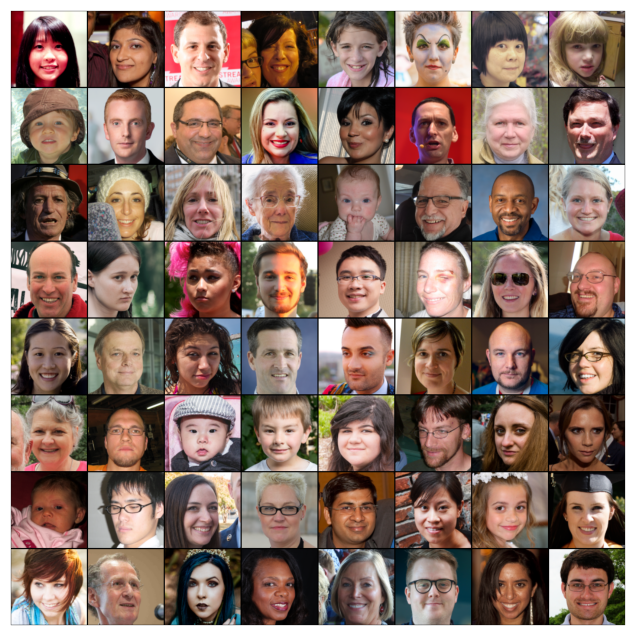

In [88]:
show_batch(photos_loader)

Готово

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [89]:
class Add_noise(nn.Module):
    def __init__(self, noise_factor=0.05, add=True):
        super(Add_noise, self).__init__()
        self.nf = noise_factor
        self.add = add

    def forward(self,x):
        if self.add:
          x = x + self.nf * torch.rand(x.size()).to(device)
        else:
          x = x - self.nf * torch.rand(x.size()).to(device)
        return x

In [90]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2),
    # out: 32 x 64 x 64



    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2),
    # out: 64 x 32 x 32


    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),
    # out: 128 x 16 x 16


    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),
    # out: 128 x 8 x 8

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2),
    # out: 256 x 4 x 4


    nn.Flatten(),
    nn.Dropout(0.2),

    nn.Linear(4*4*256, 1),


    nn.Sigmoid())




In [91]:
discriminator = discriminator.to(device)

In [92]:
latent_size = 128 # choose latent size

generator =  nn.Sequential(
    # in: latent_size

    nn.Linear(latent_size, 4*4*256),
    nn.Unflatten(1,(256,4,4)),
    nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2),

    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2),

    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),

    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2),

    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2),

    # out: 64 x 128 x 128


    nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1, bias=False),
    nn.Tanh()


    # out: 3 x 128 x 128





)

In [93]:
generator = generator.to(device)

In [94]:
!pip install torchsummary

In [95]:
from torchsummary import summary

In [96]:
summary(generator,(128,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]         528,384
         Unflatten-2            [-1, 256, 4, 4]               0
   ConvTranspose2d-3            [-1, 256, 8, 8]       1,048,576
       BatchNorm2d-4            [-1, 256, 8, 8]             512
         LeakyReLU-5            [-1, 256, 8, 8]               0
   ConvTranspose2d-6          [-1, 256, 16, 16]       1,048,576
       BatchNorm2d-7          [-1, 256, 16, 16]             512
         LeakyReLU-8          [-1, 256, 16, 16]               0
   ConvTranspose2d-9          [-1, 128, 32, 32]         524,288
      BatchNorm2d-10          [-1, 128, 32, 32]             256
        LeakyReLU-11          [-1, 128, 32, 32]               0
  ConvTranspose2d-12           [-1, 64, 64, 64]         131,072
      BatchNorm2d-13           [-1, 64, 64, 64]             128
        LeakyReLU-14           [-1, 64,

In [97]:
summary(discriminator,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,536
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         LeakyReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          32,768
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         LeakyReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]         131,072
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 128, 8, 8]         262,144
      BatchNorm2d-11            [-1, 128, 8, 8]             256
        LeakyReLU-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 256, 4, 4]         524,288
      BatchNorm2d-14            [-1, 25

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [98]:
# # Инициализация весов модели с помощью нормального распределения
# def initialize_weights(model):
#     for m in model.modules():
#         if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#             nn.init.normal_(m.weight, mean=0, std=1)
#             if m.bias is not None:
#                 nn.init.constant_(m.bias, 0)



# initialize_weights(generator)
# initialize_weights(discriminator)

In [99]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [100]:
fixed_latent = torch.randn(batch_size, latent_size, device=device)

In [101]:
def save_samples(index, latent_tensors, show=True):
    generator.eval()
    with torch.no_grad():
        fake_images = generator(latent_tensors)

    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images.detach().cpu()), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [102]:
lr = 0.0002

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}


In [103]:
def fit(model, data, criterion, epochs, lr):

    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.99)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.99))
    }

    for epoch in range(epochs):
        model["generator"].train()
        model["discriminator"].train()
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(data):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()


            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images.to(device))
            real_targets = torch.zeros(real_images.size(0), 1, device=device) #я почему-то взял 0 класс для обычных картинок и 1 для сгенерированных
            real_targets = Add_noise().forward(real_targets)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.ones(fake_images.size(0), 1, device=device) #я почему-то взял 0 класс для обычных картинок и 1 для сгенерированных
            fake_targets = Add_noise(add=False).forward(fake_targets)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images

            latent = torch.randn(batch_size, latent_size, device=device)
            fake_images = model["generator"](latent)


            # Try to fool the discriminator

            preds = model["discriminator"](fake_images)
            targets = torch.zeros(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))



        #Show some generated images on current epoch
        model["generator"].eval()
        with torch.no_grad():
            latent = torch.randn(5, latent_size, device=device)
            to_show_images = model["generator"](latent).detach().cpu()
            to_show_images = denorm(to_show_images)

        clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.axis("off")
            plt.imshow(to_show_images[i].permute(1, 2, 0).numpy())
            plt.title('Generated Photos')
        plt.show()

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))


        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+1, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores




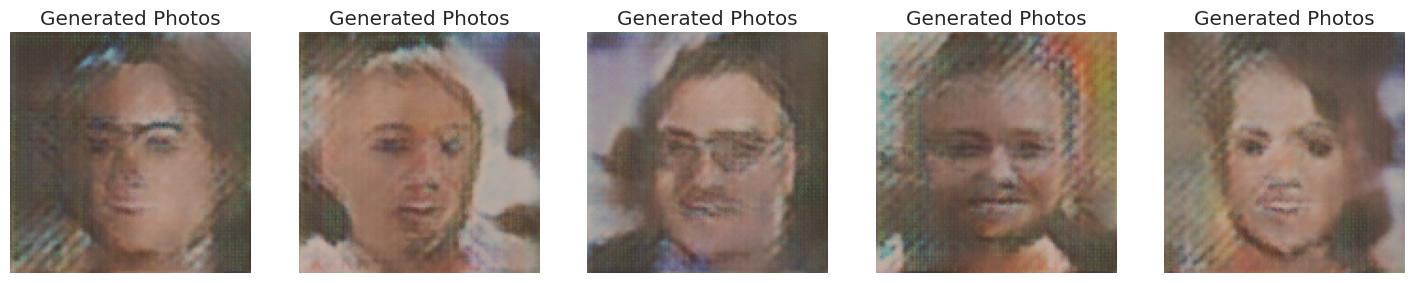

Epoch [30/30], loss_g: 2.3142, loss_d: 0.9328, real_score: 0.3169, fake_score: 0.6934
Saving generated-images-0030.png


In [104]:
losses_g, losses_d, real_scores, fake_scores = fit(model, photos_loader, criterion, 30, lr)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

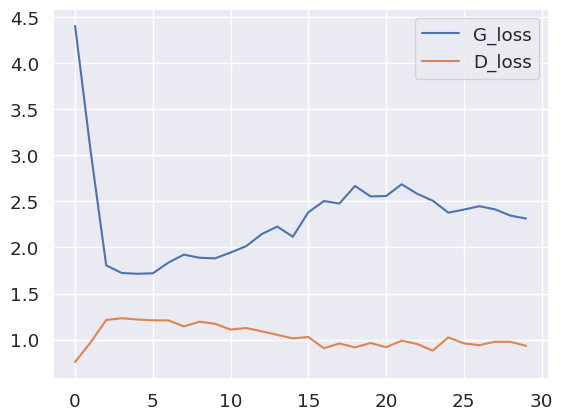

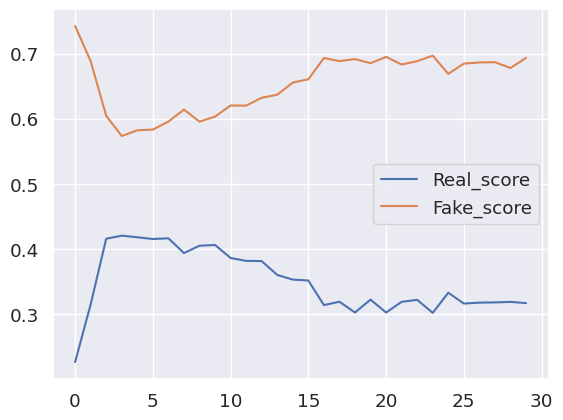

In [107]:
plt.plot(range(30),losses_g,label='G_loss')
plt.plot(range(30),losses_d,label='D_loss')
plt.legend()
plt.show()

plt.plot(range(30),real_scores,label='Real_score')
plt.plot(range(30),fake_scores, label='Fake_score')
plt.legend()
plt.show()


Графики обучения адекватные: мы видим что сначала лосс генератора очень высокий затем он резко подает (улучшается его работа),
в тоже время классификатор начинает с довольно низкого лосса который потом растет (генератору получается вводить его в заблуждение) но затем опять имеет тренд к снижению

На графике скора мы видим что дискриминатор все таки хорошо обучился и в среднем правильно предсказывает 1 фейковым картинкам (1 это класс фейка у меня) среднее значение предсказаний фейку ~0.7

В целом модель можно было бы поучить подольше так как мы видим что у генератора еще есть потенциал к обучению, так как дискриминатор уверен в фейках только на ~70%, значение лосса довольно высокое, а следовательно к генератору идут градиенты(обратная связь от дискриминатора)

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [108]:
import copy
import pickle

In [109]:
gen_weights = copy.deepcopy(generator.state_dict())
discr_weights = copy.deepcopy(discriminator.state_dict())

cохраним модели на будущее

In [111]:
with open('gen.pkl', 'wb') as gen, open('dis.pkl', 'wb') as dis, open('stats.pkl','wb') as stat:
    pickle.dump(gen_weights,gen)
    pickle.dump(discr_weights,dis)
    pickle.dump((losses_g, losses_d, real_scores, fake_scores),stat)

In [130]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, device=device)
fake_images = model["generator"](fixed_latent)

In [131]:
def show_images(generated):
    generated = generated.detach().cpu()
    generated = denorm(generated)
    plt.figure(figsize=(18, 18))
    for i, pic in enumerate(generated):
        plt.subplot(1, generated.size()[0],i+1)
        plt.axis("off")
        plt.imshow(pic.permute(1, 2, 0).numpy())
        plt.title('Generated Photos')
    plt.show()

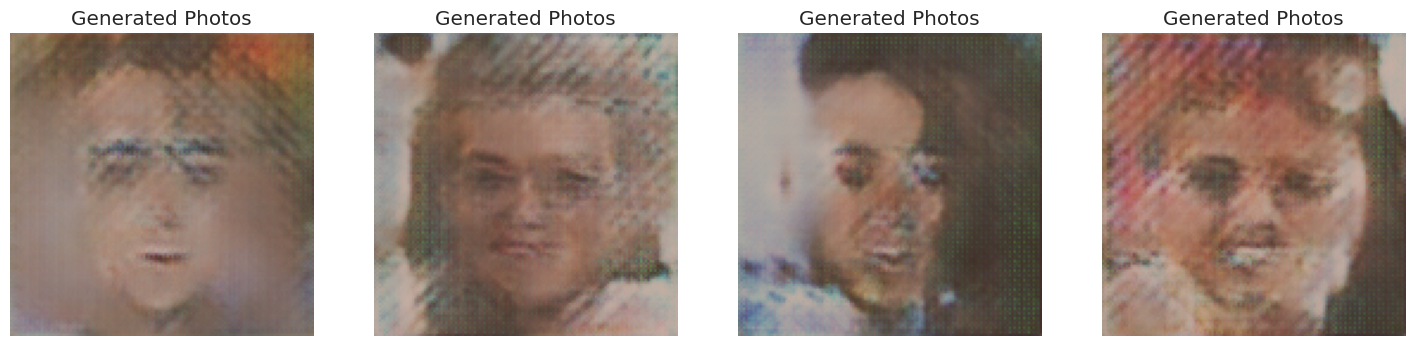

In [132]:
show_images(fake_images)

Как вам качество получившихся изображений?

Не очень ) Но что поделать, для качественных картинок нужны более продвинутые архитектуры типа Progressive GAN, возможно другие loss функции и много GPU ресурсов )

Но главная цель - понять принцип работы и что-то смастерить самому достигнута

И в целом мы видим лица с нормальными распознаваемыми чертами лица и в правильной цветовой гамме

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Не вижу смысла делать оценку по 3143+3143 фотографиям,обучать >6000 раз KNN.
возьмем для оценки 500+500

In [155]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [182]:
#генерируем 500 изображений
n_images = 500
fixed_latent = torch.randn(n_images, latent_size)

latents = DataLoader(fixed_latent, batch_size=128,
                      shuffle=False,
                      num_workers=2,
                     )


model["generator"].eval()
generated = torch.Tensor([])
for latents_batch in tqdm(latents):
    with torch.no_grad():
        latents_batch = latents_batch.to(device)
        fake_images = model["generator"](latents_batch)
        fake_images = fake_images.detach().cpu()
        fake_images = denorm(fake_images)  #ВАЖНО!!! денормировка ведь выход модели имеет цвета с мю 0 и сигма 1 и надо вернуть к норамальным цветам
        generated = torch.cat([generated, fake_images], dim=0)


generated.size()

  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([500, 3, 128, 128])

In [183]:
#сделаем метки для сгенерированных изображений
gen_labels = np.zeros(500)

gen_labels.shape

(500,)

In [184]:
#Оригинальные фотографии
photos[0].size()

original = photos[0].numpy()
original.shape

(3143, 3, 128, 128)

In [195]:
#выберем 500 случайных фотографий для это сгенирируем 500 случайных индексов
idx = np.random.permutation(np.arange(0,3142,1))[0:500]
idx.shape

(500,)

In [196]:
#наши случайные фотки
original = original[idx]

In [198]:
#переведем сгенерированные фотографии в numpy
generated = generated.numpy()
generated.shape

(500, 3, 128, 128)

In [199]:
#сделаем метки для оригинальных изображений
orig_labels = np.ones(500)

orig_labels.shape

(500,)

In [200]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut


sklearn.neighbors._classification.KNeighborsClassifier

In [235]:
#cоздадим данные для обучения KNN объединив оригинальные и сгенерированные фотографии и их метки в X и y и распрямим наши фотографии 
X = np.r_[generated,original]
y = np.r_[gen_labels,orig_labels]

X = X.reshape(1000,3*128*128)


Проверим все ли ок с нашими решейпами и объединением. Свернем обратно до изображений и проверим получатеся или нет исходная картинка

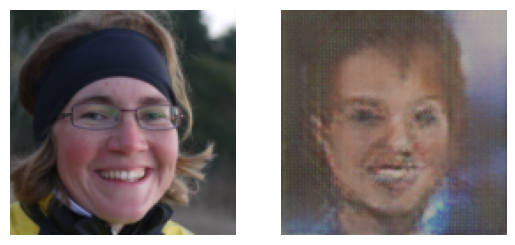

In [243]:
orig_test = X[800] 
gen_test = X[200]
orig_test = orig_test.reshape(3,128,128)
gen_test = gen_test.reshape(3,128,128)
orig_test = np.rollaxis(orig_test, 0,3)
gen_test = np.rollaxis(gen_test, 0,3)

plt.subplot(1,2,1)
plt.imshow(orig_test)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gen_test)
plt.axis('off')
plt.show()


Все ок

In [210]:
loo = LeaveOneOut()
loo.get_n_splits(X)
acc = []
for i, (train_index, test_index) in tqdm(enumerate(loo.split(X))):
    knn_clf = KNeighborsClassifier(n_neighbors=1)
    knn_clf.fit(X[train_index],y[train_index])
    acc.append(knn_clf.score(X[test_index],y[test_index]))
    


0it [00:00, ?it/s]

In [211]:
print(f'Accuracy: {sum(acc)/len(acc)}')

Accuracy: 0.609


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Мы получили хороший результат близкий к 0.5. Наша цель чтобы фотографии сгенерированные и оригинальные были похоже и соответственно не различимы для простого классификатора, соответственно мы хоти получить accuracy -> 0.5

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

/tmp/ipykernel_42/2273736724.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_repr[mask, 0], tsne_repr[mask, 1], s=2, c=class_colors[label], label=label)


Text(0.5, 1.0, 't-SNE визуализация оригинальных и сгенерированных изображений')

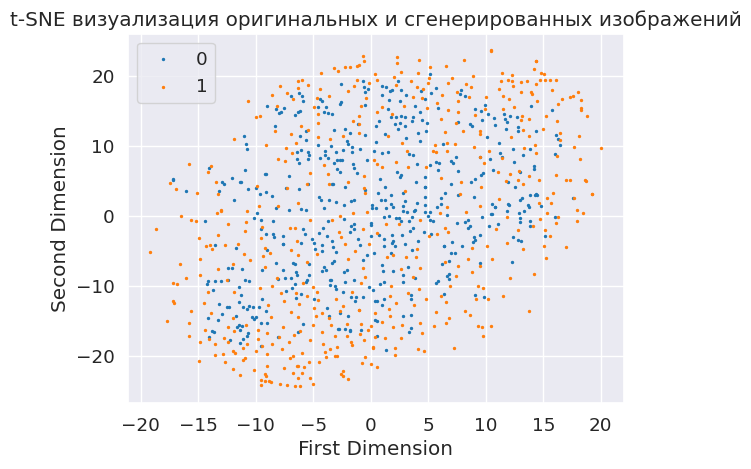

In [236]:
from sklearn.manifold import TSNE

tsne = TSNE() #инициации TSNE


labels_unique = [0,1] #уникальные метки

tsne_repr = tsne.fit_transform(X) 

#готовим карту цветов

colors = plt.get_cmap('tab10').colors

num_classes = len(labels_unique)

class_colors = dict(zip(range(num_classes), colors))

#строим scatter-plot наших латентных векторов после их переноса в двумерное пространство
for label in labels_unique:
    mask = y == label
    plt.scatter(tsne_repr[mask, 0], tsne_repr[mask, 1], s=2, c=class_colors[label], label=label)

plt.legend()


plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('t-SNE визуализация оригинальных и сгенерированных изображений')


Прокомментируйте получившийся результат:

Получившийся результат хороший: оригинальные и сгенерированные картинки имеют схожее распределение на двумерной плоскости, единственное точки оригинальных фотографией немного кучнее (облако сгенерированных картинок немного шире)